In [39]:
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xlwings as xw
from collections import defaultdict
import copy
from math import trunc
import email
import spacy
import tqdm
import gensim
import gensim.corpora as corpora
import nltk
import re

nlp=spacy.load("en_core_web_sm",disable=["tagger", "parser","ner"])  #Only Tokennize
plt.rc('font', size="12")

from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint


stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lewis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
id_to_top_cat={1: "Coarse genre",
         2: "Included/forwarded information",
         3: "Primary topics",
         4: "Emotional tone"}

id_to_sub_cat={1: {1: "Company Business, Strategy",
             2: "Purely Personal",
             3: "Personal but in professional context",
             4: "Logistic Arrangements",
             5: "Employment arrangements",
             6: "Document editing/checking",
             7: "Empty message (missing attachment)",
             8: "Empty message"},

         2: {1 : "Includes new text in addition to forwarded material",
             2 : "Forwarded email(s) including replies",
             3 : "Business letter(s) / document(s)",
             4 : "News article(s)",
             5 : "Government / academic report(s)",
             6 : "Government action(s)",
             7 : "Press release(s)",
             8 : "Legal documents",
             9 : "Pointers to url(s)",
             10: "Newsletters",
             11: "Jokes, humor (related to business)",
             12: "Jokes, humor (unrelated to business)",
             13: "Attachment(s) (assumed missing)"},

         3:{ 1  : "regulations and regulators (includes price caps)",
             2  : "internal projects -- progress and strategy",
             3  : "company image -- current",
             4  : "company image -- changing / influencing",
             5  : "political influence / contributions / contacts",
             6  : "california energy crisis / california politics",
             7  : "internal company policy",
             8  : "internal company operations",
             9  : "alliances / partnerships",
             10 : "legal advice",
             11 : "talking points",
             12 : "meeting minutes",
             13 : "trip reports"},

         4:{ 1  : "jubilation",
             2  : "hope / anticipation",
             3  : "humor",
             4  : "camaraderie",
             5  : "admiration",
             6  : "gratitude",
             7  : "friendship / affection",
             8  : "sympathy / support",
             9  : "sarcasm",
             10 : "secrecy / confidentiality",
             11 : "worry / anxiety",
             12 : "concern",
             13 : "competitiveness / aggressiveness",
             14 : "triumph / gloating",
             15 : "pride",
             16 : "anger / agitation",
             17 : "sadness / despair",
             18 : "shame",
             19 : "dislike / scorn"}}

In [3]:
def get_labels(filename):
    with open(filename + '.cats') as f:
        labels = defaultdict(dict)
        line = f.readline()
        while line:
            line = line.split(',')
            top_cat, sub_cat, freq = int(line[0]), int(line[1]), int(line[2])
            labels[top_cat][sub_cat] = freq
            line = f.readline()
    return dict(labels)

def check_category(filename, top_cat, sub_cat):
    labels = get_labels(filename)
    if sub_cat in labels[top_cat]:
        return 1
    return 0

def get_binary_labels(filenames, top_cat, sub_cat):
    flags = []
    for filename in filenames:
        flags.append(check_category(filename, top_cat, sub_cat))
    return flags

In [4]:
print(glob.glob('./*/*/*.cats'))

['.\\enron_with_categories\\1\\10425.cats', '.\\enron_with_categories\\1\\106296.cats', '.\\enron_with_categories\\1\\106298.cats', '.\\enron_with_categories\\1\\106588.cats', '.\\enron_with_categories\\1\\106590.cats', '.\\enron_with_categories\\1\\109359.cats', '.\\enron_with_categories\\1\\110549.cats', '.\\enron_with_categories\\1\\113953.cats', '.\\enron_with_categories\\1\\114087.cats', '.\\enron_with_categories\\1\\114503.cats', '.\\enron_with_categories\\1\\114715.cats', '.\\enron_with_categories\\1\\114844.cats', '.\\enron_with_categories\\1\\114845.cats', '.\\enron_with_categories\\1\\114847.cats', '.\\enron_with_categories\\1\\115139.cats', '.\\enron_with_categories\\1\\115140.cats', '.\\enron_with_categories\\1\\115175.cats', '.\\enron_with_categories\\1\\115317.cats', '.\\enron_with_categories\\1\\115322.cats', '.\\enron_with_categories\\1\\115333.cats', '.\\enron_with_categories\\1\\115439.cats', '.\\enron_with_categories\\1\\115495.cats', '.\\enron_with_categories\\1\\11

In [5]:
email_files = [f.replace('.cats', '') for f in glob.glob('./*/*/*.cats')]
top_cnt=dict([(k,0) for k,v in id_to_top_cat.items()])
category_freq = dict([(k,dict([(k2,0) for k2,_ in v.items()])) for k,v in id_to_sub_cat.items()])
category_cnt = copy.deepcopy(category_freq)
total_freq = 0
label_freq = 0
labeled_files = []

for email_file in email_files:
    labels = get_labels(email_file)
    for top_cat in labels:
        top_cnt[top_cat]+=1
        for sub_cat in labels[top_cat]:
            total_freq += labels[top_cat][sub_cat]

    
        has_label = False
        for sub_cat in labels[top_cat]:
            freq = labels[top_cat][sub_cat]
            category_freq[top_cat][sub_cat] += freq
            category_cnt[top_cat][sub_cat] += 1
            label_freq += freq
            has_label = True
        if has_label:
            labeled_files.append(email_file)

In [6]:
def plot_freq(x_dict,cnt_dict,figsize=(10,5),xlabel="",title=""):
    x,y=[],[]
    for k,v in x_dict.items():
        x.append(v)
        y.append(cnt_dict[k])
    y=np.array(y)
    y_srt=np.argsort(y)
    x=np.array(x)[y_srt]
    y=y[y_srt]
    plt.figure(figsize=figsize)
    ax=plt.subplot()
    _=ax.barh(x,y)
    max_x=max(y)
    #tick_gap=50 if max_x%1000==max_x else 100
    #_=ax.set_xticks(range(0,max_x+tick_gap,tick_gap))
    tick_gap=ax.get_xticks()[1]-ax.get_xticks()[0]
    ax.set_xlim(0,round(max_x,-1)+tick_gap/2)
    _=ax.set_yticks(range(len(x)))
    #_=ax.set_yticklabels(x, rotation = rotation,ha=ha)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for k,v in enumerate(y):
        ax.annotate(v,(v-len(str(v))*(tick_gap/8),k-.1),color="white")

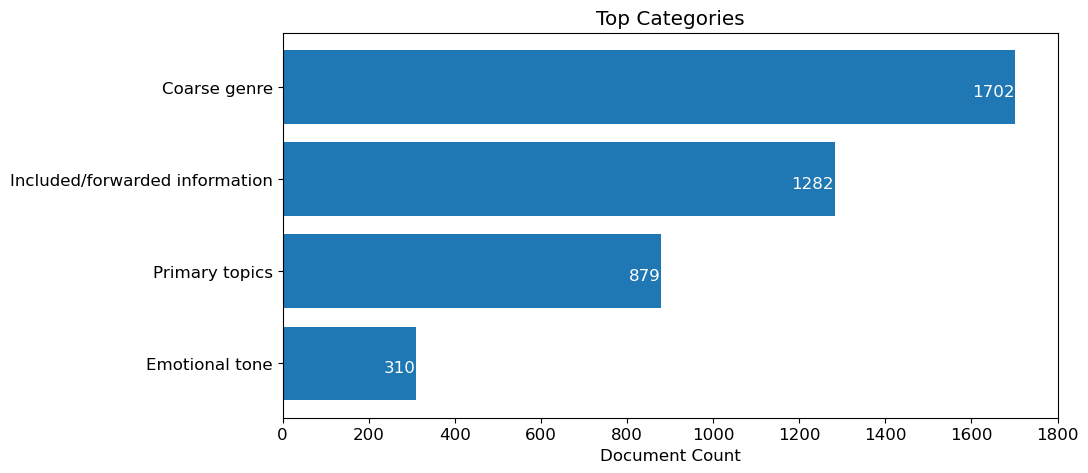

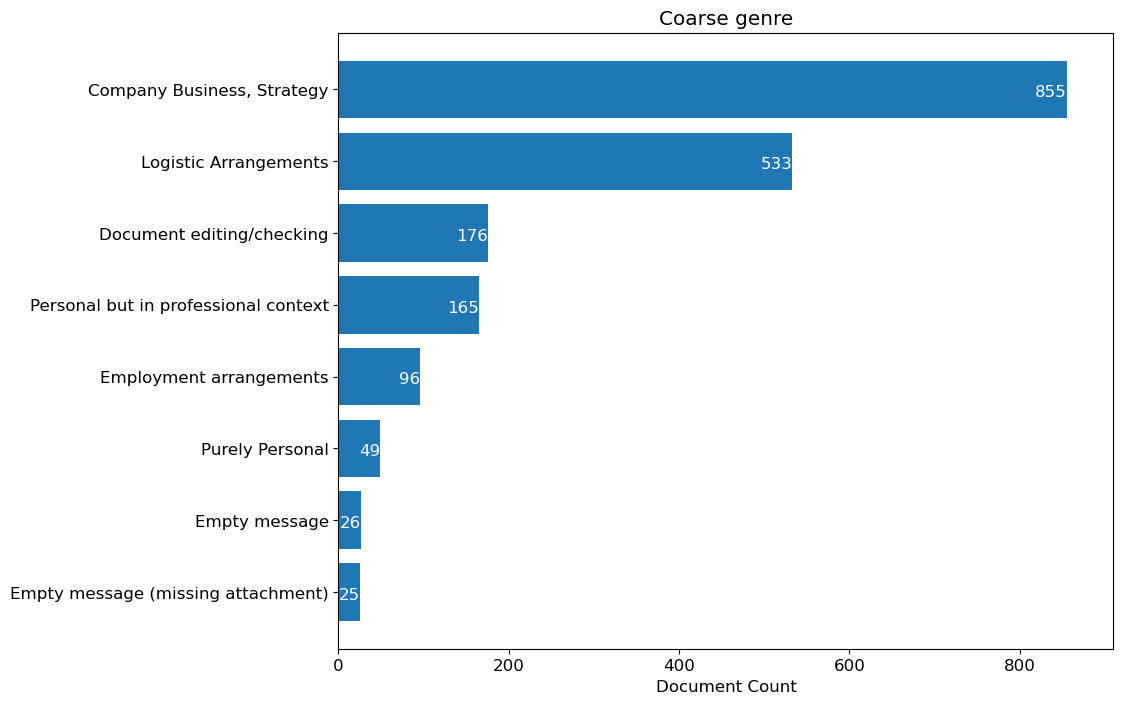

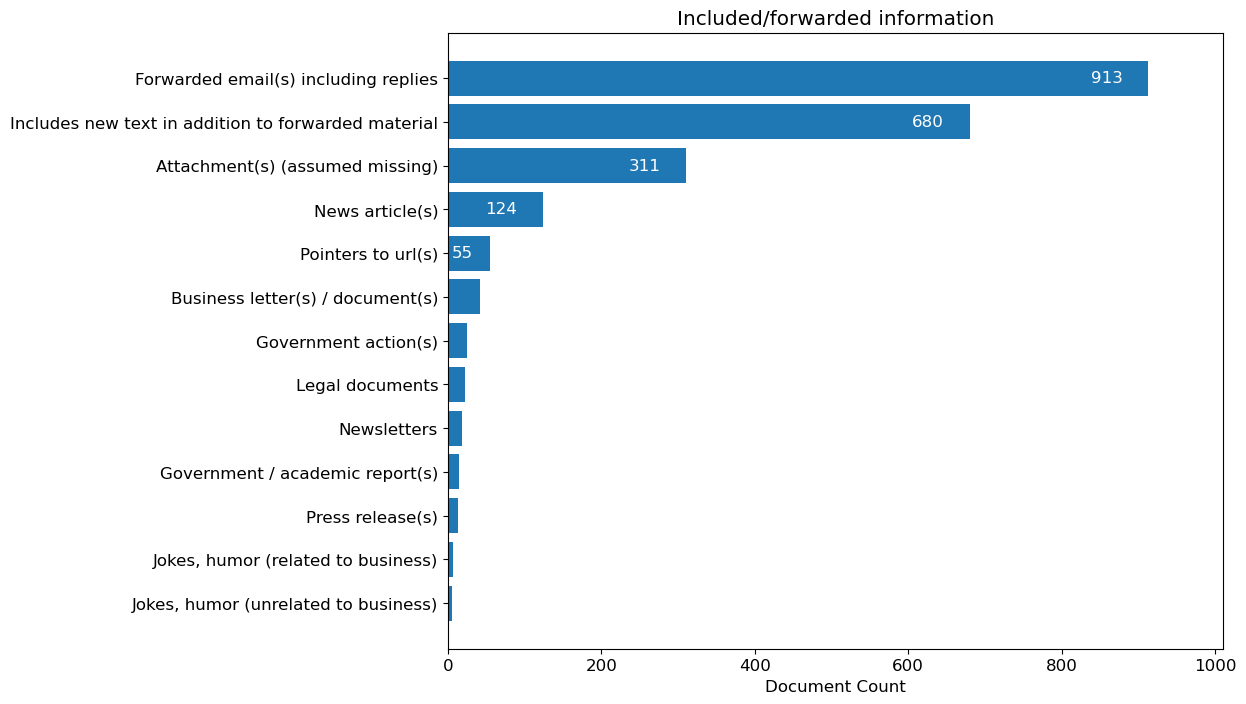

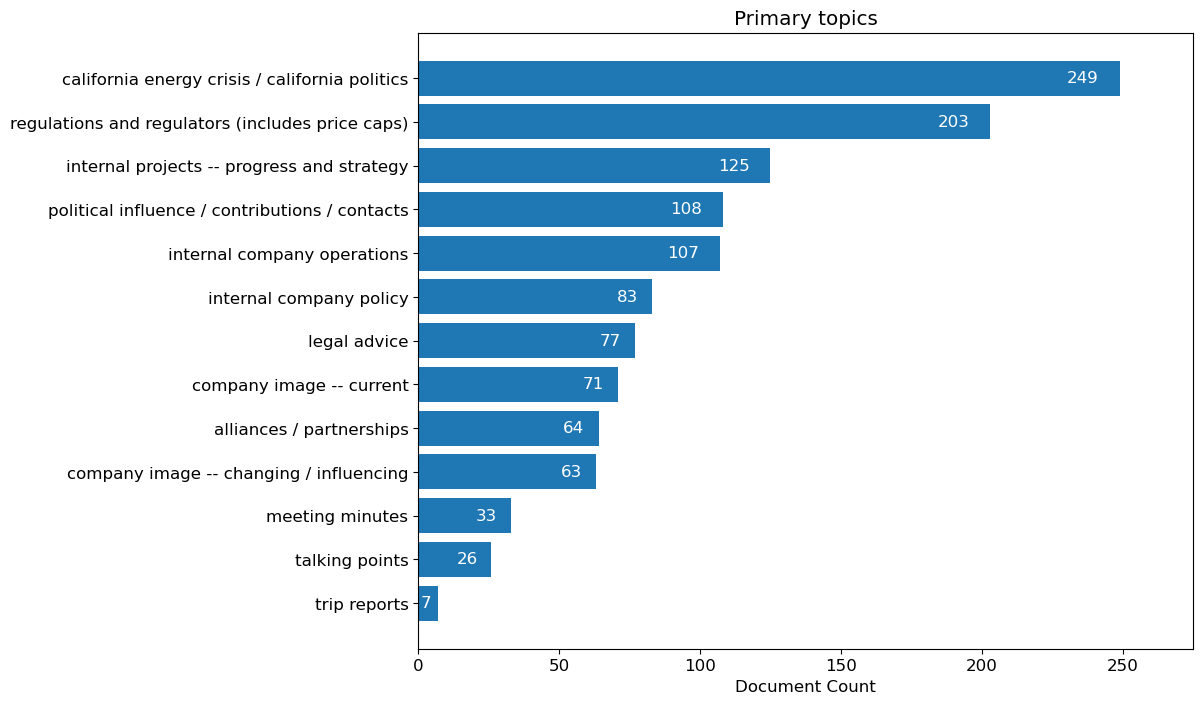

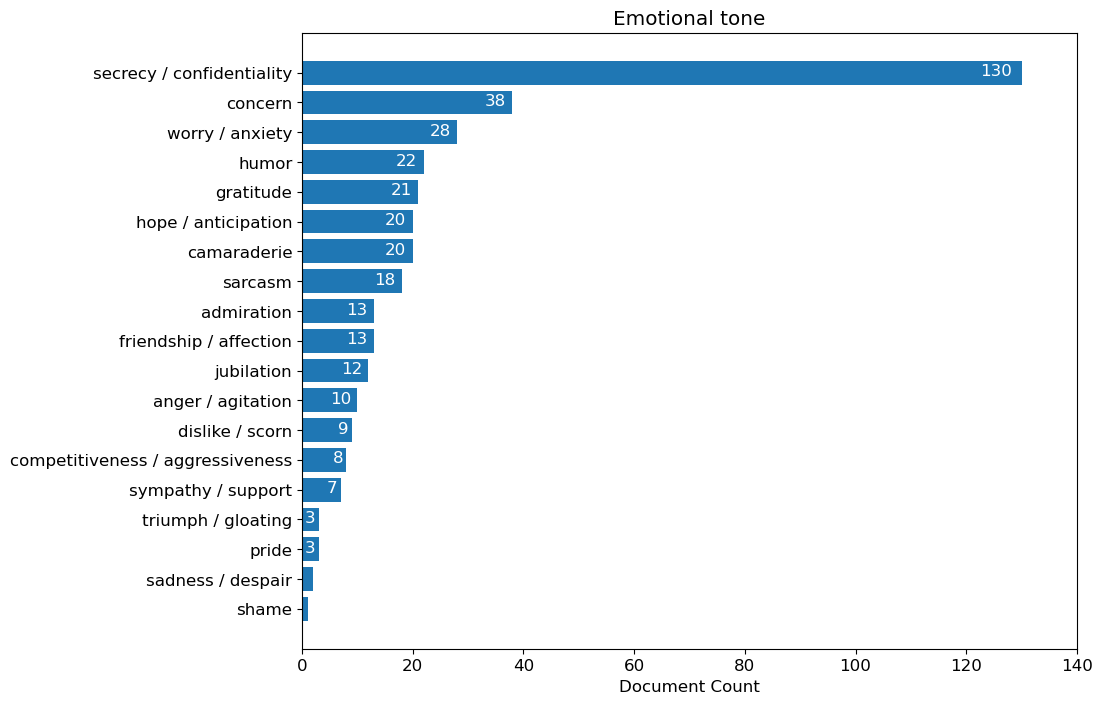

In [7]:
x=[id_to_top_cat[k] for k in top_cnt.keys()]
plot_freq(id_to_top_cat,top_cnt,xlabel="Document Count",title="Top Categories")
for k in category_cnt:
    plot_freq(id_to_sub_cat[k],category_cnt[k],figsize=(10,8),xlabel="Document Count",title=id_to_top_cat[k])

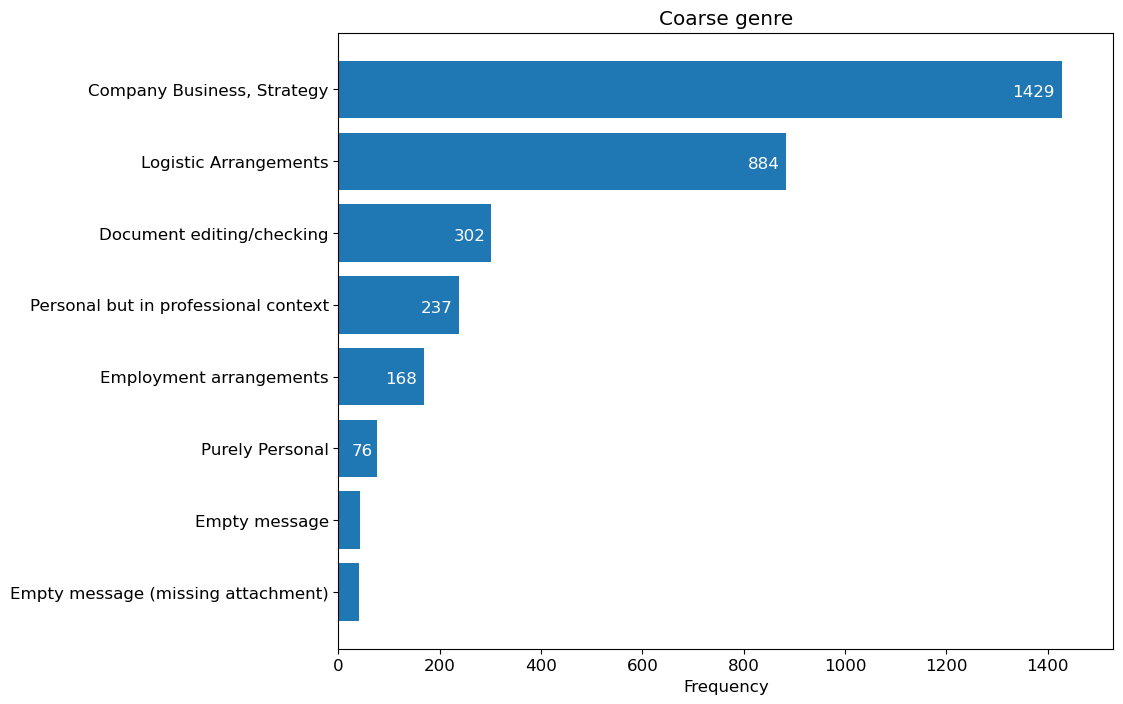

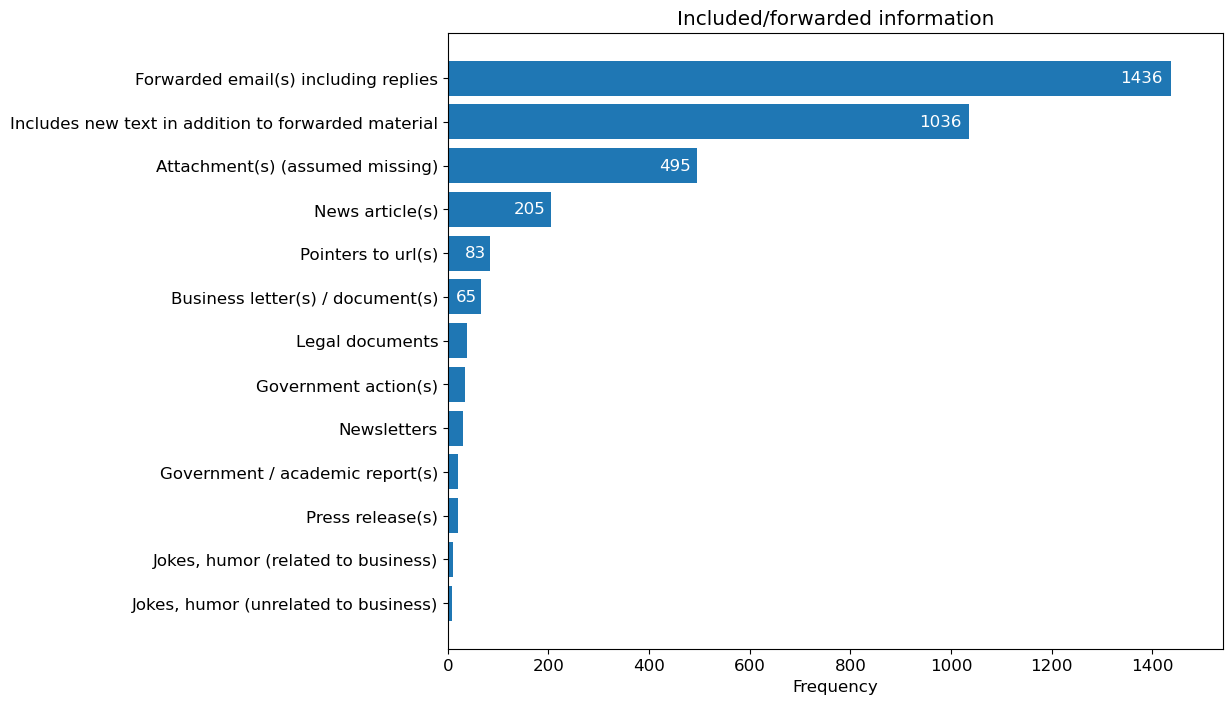

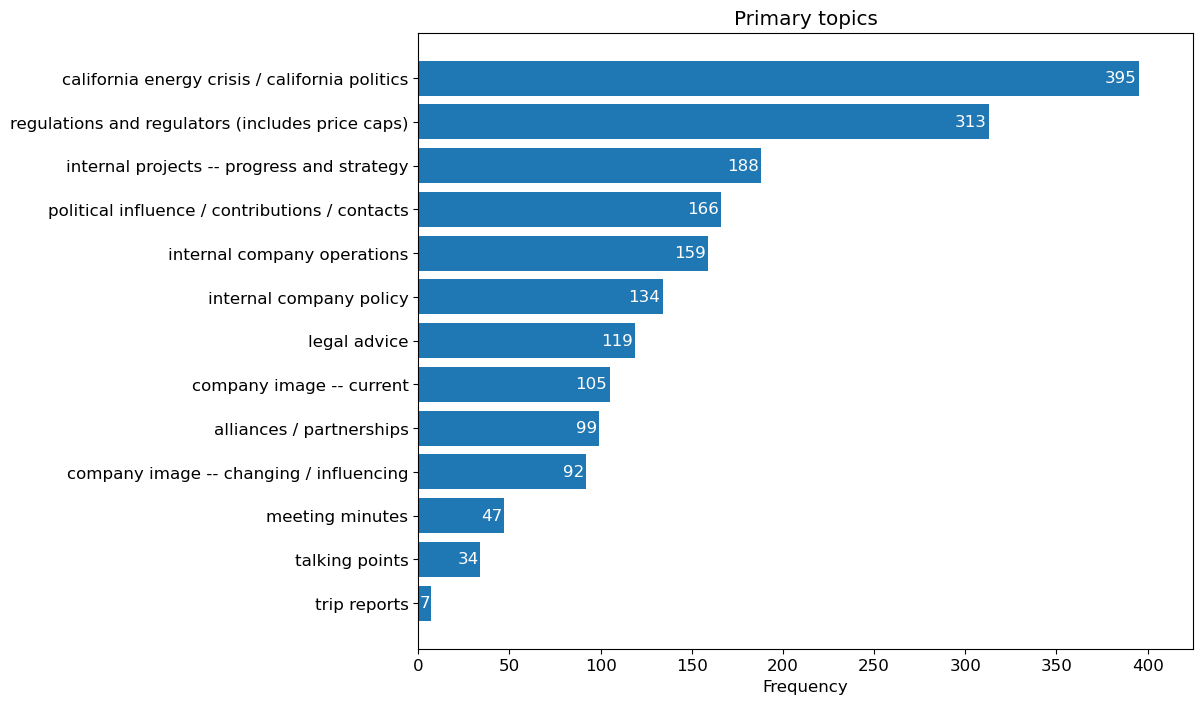

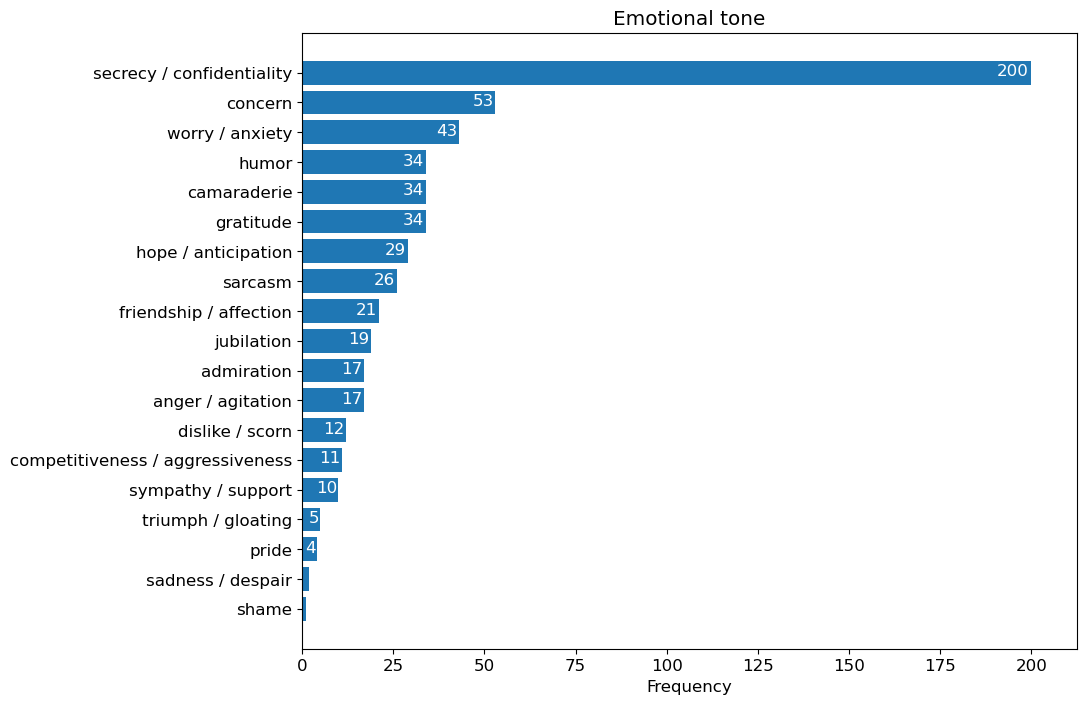

In [8]:
for k in category_freq:
    plot_freq(id_to_sub_cat[k],category_freq[k],figsize=(10,8),xlabel="Frequency",title=id_to_top_cat[k])

## Preprocess

In [9]:
def nlp_tokenize_lower(string):
    return [token.text.lower() for token in nlp(string)]

In [10]:
def read_email_file(filename):
    with open(filename) as f:
        message = email.message_from_file(f)
    return message

In [11]:
def preprocess(filename):
    message=read_email_file(filename)
    file_categories = get_labels(filename[:-4])
    isPersonal = 0
    if 1 in file_categories:
        if 2 in file_categories[1] or 3 in file_categories[1]:
            isPersonal = 1
    words = []
    message_count = 1
    include_text = True
    body = message.get_payload()
    for line in body.split('\n'):
        message_count += 1
        include_text = False
        words.extend(nlp_tokenize_lower(line))
    
    return {"File":filename, "To":message['To'], "From":message['From'],"body":body,"message":words, "count": message_count, "IsPersonal": isPersonal}

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in texts]

In [13]:

content=[]
for f in tqdm.tqdm(email_files):
    content.append(preprocess(f+".txt"))

  0%|          | 0/1702 [00:00<?, ?it/s]c:\Users\Lewis\anaconda3\envs\Tensorenv\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 1702/1702 [20:14<00:00,  1.40it/s] 


In [14]:
vocab={}
for c in tqdm.tqdm(content):
    for w in c["message"]:
        if w in vocab:
            vocab[w]+=1
        else:
            vocab[w]=1

100%|██████████| 1702/1702 [00:01<00:00, 1199.18it/s]


In [15]:
message_length=np.array([len(c["message"]) for c in content])

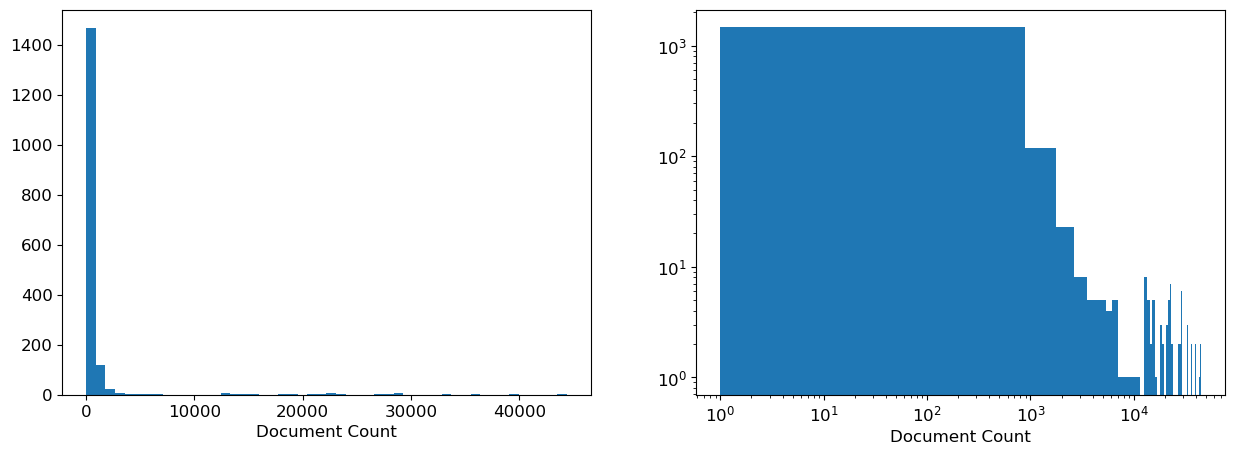

In [16]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
ax=axs[0]
for ax in axs:
    _=ax.hist(message_length,bins=50)
    _=ax.set_xlabel("words")
    _=ax.set_xlabel("Document Count")

axs[1].set_yscale("log")
axs[1].set_xscale("log")

In [17]:
def pct_length(pct_at,text=True):
    res=round(100*message_length[message_length<pct_at].shape[0]/message_length.shape[0],2)
    if(text):
        return f"Documents with atleast {pct_at} words\t: {res}%"
    else:
        return res

In [18]:
print(f"Total Documents: {len(email_files)}")
print(f"Mean Document length (words): {round(np.mean(message_length),2)}")
print(f"Unique words: {len(vocab)}")
print(pct_length(512))
print(pct_length(1000))

Total Documents: 1702
Mean Document length (words): 1291.28
Unique words: 45341
Documents with atleast 512 words	: 72.27%
Documents with atleast 1000 words	: 87.78%


In [19]:
lbls=get_labels(email_files[67])

In [20]:
lbls

{1: {1: 2}, 2: {1: 2, 2: 2}, 3: {5: 1, 10: 2}, 4: {10: 2}}

In [21]:
lbls.items()

dict_items([(1, {1: 2}), (2, {1: 2, 2: 2}), (3, {5: 1, 10: 2}), (4, {10: 2})])

In [22]:
m_top,m_sub

NameError: name 'm_top' is not defined

In [23]:
def get_max_categ(lbls):
    m_top,m_sub=0,0
    mx=0
    for tk,tv in lbls.items():
        for sk,sv in tv.items():
            if sv>mx:
                m_top,m_sub=tk,sk
                mx=sv
    return m_top,m_sub

In [24]:
top,sub=2,13
for idx,file in enumerate(email_files):
    lbls=get_labels(file)
    m_top,m_sub=get_max_categ(lbls)
    if(top == m_top and sub ==m_sub):
        print(file,lbls[top][sub],read_email_file(file+".txt"))
        break

.\enron_with_categories\1\116118 2 Message-ID: <14808936.1075842995332.JavaMail.evans@thyme>
Date: Wed, 11 Oct 2000 07:12:00 -0700 (PDT)
From: susan.mara@enron.com
To: jeff.dasovich@enron.com
Subject: Fwd:
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: Susan J Mara
X-To: Jeff Dasovich
X-cc: 
X-bcc: 
X-Folder: \Jeff_Dasovich_Dec2000\Notes Folders\All documents
X-Origin: DASOVICH-J
X-FileName: jdasovic.nsf

---------------------- Forwarded by Susan J Mara/SFO/EES on 10/11/2000 12:12 
PM ---------------------------


"Daniel Douglass" <douglass@ArterHadden.com> on 10/11/2000 12:54:40 PM
To: <Barbara_Klemstine@apsc.com>, <Bob_Anderson@apses.com>, <berry@apx.com>, 
<dcazalet@apx.com>, <billr@calpine.com>, <jackp@calpine.com>, 
<glwaas@calpx.com>, <Ken_Czarnecki@calpx.com>, <cabaker@duke-energy.com>, 
<rjhickok@duke-energy.com>, <GTBL@dynegy.com>, <KEWH@dynegy.com>, 
<j_dasovi@ect.enron.com>, <rpelote@energy.twc.com>, <susan_j_mara@

In [25]:
category_freq

{1: {1: 1429, 2: 76, 3: 237, 4: 884, 5: 168, 6: 302, 7: 40, 8: 42},
 2: {1: 1036,
  2: 1436,
  3: 65,
  4: 205,
  5: 21,
  6: 34,
  7: 20,
  8: 38,
  9: 83,
  10: 31,
  11: 11,
  12: 8,
  13: 495},
 3: {1: 313,
  2: 188,
  3: 105,
  4: 92,
  5: 166,
  6: 395,
  7: 134,
  8: 159,
  9: 99,
  10: 119,
  11: 34,
  12: 47,
  13: 7},
 4: {1: 19,
  2: 29,
  3: 34,
  4: 34,
  5: 17,
  6: 34,
  7: 21,
  8: 10,
  9: 26,
  10: 200,
  11: 43,
  12: 53,
  13: 11,
  14: 5,
  15: 4,
  16: 17,
  17: 2,
  18: 1,
  19: 12}}

In [26]:
Personal = []
NonPersonal = []
for c in content:
    if c['IsPersonal'] == 1:
        Personal.append(c)
    else:
        NonPersonal.append(c)

Personaldf = pd.DataFrame(Personal)
NonPersonaldf = pd.DataFrame(NonPersonal)

Personaldf['category'] = 'Personal'
NonPersonaldf['category'] = 'Non Personal'

df_list = [Personaldf, NonPersonaldf]
df = pd.concat(df_list).reset_index(drop=True)

def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in x])

df['lemma'] = df['message'].map(lemmatize)

X = df['lemma']
Y = df['IsPersonal']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=13)



In [27]:
pipe_mnnb = Pipeline(steps = [('tf', TfidfVectorizer()), ('mnnb', MultinomialNB())])

pgrid_mnnb = {
    'tf__max_features' : [1000, 2000, 3000],
    'tf__stop_words' : ['english', None],
    'tf__ngram_range' : [(1,1), (1,2)],
    'tf__use_idf' : [True, False],
    'mnnb__alpha' : [0.1, 0.5, 1]
}

gs_mnnb = GridSearchCV(pipe_mnnb, pgrid_mnnb,cv=3,n_jobs=-1)

gs_mnnb.fit(X_train, Y_train)

print(gs_mnnb.score(X_train, Y_train))
print(gs_mnnb.score(X_test, Y_test))

0.9114420062695925
0.903755868544601


In [28]:
pipe_svc = Pipeline(steps = [('tf', TfidfVectorizer()), ('svc', SVC())])

pgrid_svc = {
    'tf__max_features' : [1000, 2000, 3000],
    'tf__stop_words' : ['english', None],
    'tf__ngram_range' : [(1,1), (1,2)],
    'tf__use_idf' : [True, False],
}

gs_svc = GridSearchCV(pipe_svc, pgrid_svc,cv=3,n_jobs=-1)

gs_svc.fit(X_train, Y_train)

print(gs_svc.score(X_train, Y_train))
print(gs_svc.score(X_test, Y_test))



0.9310344827586207
0.903755868544601


In [29]:
pipe_rf = Pipeline(memory=None,
                    steps=[('tf', TfidfVectorizer()),
                     ('rf', RandomForestClassifier())],
                     verbose=False)

pgrid_rf = {
    'tf__max_features' : [1000, 2000, 3000],
    'tf__stop_words' : ['english', None],
    'tf__ngram_range' : [(1,1), (1,2)],
    'tf__use_idf' : [True, False],
}

gs_rf = GridSearchCV(pipe_rf, pgrid_rf,cv=3,n_jobs=-1)

gs_rf.fit(X_train, Y_train)

print(gs_rf.score(X_train, Y_train))
print(gs_rf.score(X_test, Y_test))



0.9945141065830722
0.9084507042253521


In [33]:

preds_mnnb = gs_mnnb.predict(X_test)
mnnb_f1 = fbeta_score(Y_test, preds_mnnb, beta=1.0)
mnnb_f2 = fbeta_score(Y_test, preds_mnnb, beta=2.0)
mnnb_precision = precision_score(Y_test, preds_mnnb)
mnnb_recall = recall_score(Y_test, preds_mnnb)

print(mnnb_f1)
print(mnnb_f2)
print(mnnb_precision)
print(mnnb_recall)

0.5060240963855421
0.43933054393305443
0.6774193548387096
0.40384615384615385


In [34]:
preds_svc = gs_svc.predict(X_test)
svc_f1 = fbeta_score(Y_test, preds_svc, beta=1.0)
svc_f2 = fbeta_score(Y_test, preds_svc, beta=2.0)
svc_precision = precision_score(Y_test, preds_svc)
svc_recall = recall_score(Y_test, preds_svc)

print(svc_f1)
print(svc_f2) 
print(svc_precision)
print(svc_recall)

0.42253521126760557
0.33039647577092507
0.7894736842105263
0.28846153846153844


In [35]:
preds_rf = gs_rf.predict(X_test)
rf_f1 = fbeta_score(Y_test, preds_rf, beta=1.0)
rf_f2 = fbeta_score(Y_test, preds_rf, beta=2.0)
rf_precision = precision_score(Y_test, preds_rf)
rf_recall = recall_score(Y_test, preds_rf)

print(rf_f1)
print(rf_f2) 
print(rf_precision)
print(rf_recall)


0.5263157894736842
0.4310344827586208
0.8333333333333334
0.38461538461538464


In [39]:
data = [
    [rf_precision, rf_recall, rf_f1, rf_f2],
    [svc_precision, svc_recall, svc_f1, svc_f2],
    [mnnb_precision, mnnb_recall, mnnb_f1, mnnb_f2]
]

pd.DataFrame(data, index=["rf","svc","nb"], columns=["precision", "recall", "F1", "F2"])

,precision,recall,F1,F2
rf,0.833333,0.384615,0.526316,0.431034
svc,0.789474,0.288462,0.422535,0.330396
nb,0.677419,0.403846,0.506024,0.439331


Text(0.5, 0, 'Feature Name')

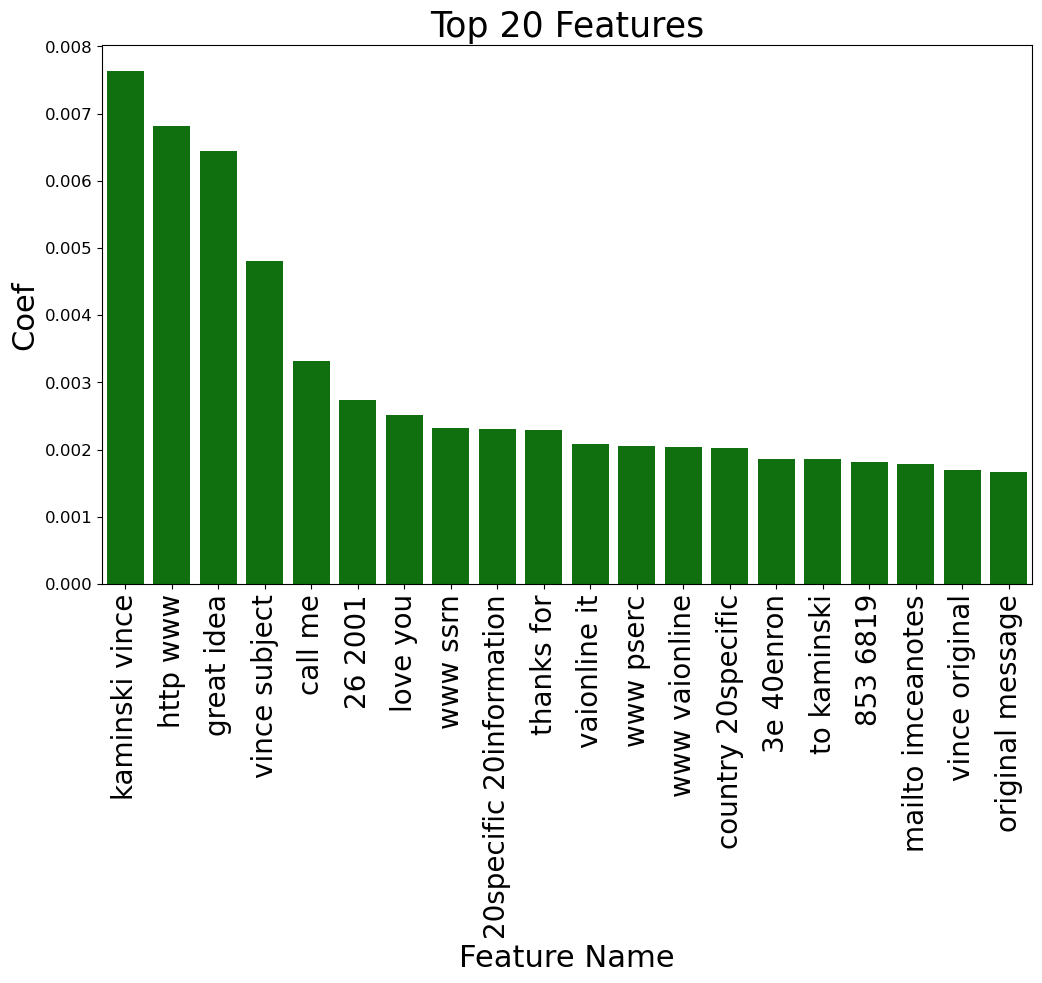

In [28]:
pipe_rf = Pipeline(memory=None,
                    steps=[('tf', TfidfVectorizer(ngram_range=(2, 2))),
                     ('rf', RandomForestClassifier())],
                     verbose=False)


pipe_rf.fit(X_train, Y_train)
feature_names = pipe_rf.named_steps["tf"].get_feature_names()
coefs = pipe_rf.named_steps["rf"].feature_importances_

pipe_rf.score(X_test, Y_test)

zipped = zip(feature_names, coefs)
fs = pd.DataFrame(zipped, columns=["feature", "value"])

fs["abs_value"] = fs["value"].apply(lambda x: abs(x))
fs["colors"] = fs["value"].apply(lambda x: "green" if x > 0 else "red")
fs = fs.sort_values("abs_value", ascending=False)

import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=fs.head(20),
           palette=fs.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [29]:
pipe_rf.score(X_test, Y_test)

0.8990610328638498

In [55]:
topic_model = pd.DataFrame(content)
topic_model = topic_model.drop(columns=['count', 'IsPersonal', 'message'])

topic_model['body_processed'] = \
topic_model['body'].map(lambda x: re.sub('[,\.!?-]', '', x))
topic_model['body_processed'] = \
topic_model['body_processed'].map(lambda x: x.lower())#

data = topic_model.body_processed.values.tolist()
data_words = list(sent_to_words(data))

data_words = remove_stopwords(data_words)

id2word = corpora.Dictionary(data_words)
texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 4), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 3), (10, 1), (11, 3), (12, 6), (13, 3), (14, 5), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 4), (28, 2), (29, 1)]


In [60]:
num_topics = 2

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
lda_model

[(0,
  '0.012*"enron" + 0.012*"said" + 0.011*"power" + 0.008*"california" + '
  '0.008*"state" + 0.007*"energy" + 0.006*"electricity" + 0.005*"would" + '
  '0.004*"gas" + 0.004*"ees"'),
 (1,
  '0.014*"power" + 0.012*"said" + 0.012*"enron" + 0.011*"state" + '
  '0.010*"energy" + 0.009*"california" + 0.006*"would" + 0.005*"electricity" + '
  '0.005*"davis" + 0.004*"prices"')]


In [61]:
assign_topics = pd.DataFrame()
for i, rowlist in enumerate(doc_lda):
    topic = 0
    percentage = 0
    for row in rowlist:
        if row[1] > percentage:
            topic = row[0]
            percentage = row[1]
    assign_topics = assign_topics.append(pd.Series([int(topic), round(percentage,4)]), ignore_index=True)
assign_topics.columns = ['Topic', 'Percentage']

topic_model = pd.concat([topic_model, assign_topics], axis=1)
topic_model
    
    

,File,To,From,body,body_processed,Topic,Percentage
0,.\enron_with_categories\1\10425.txt,"mark.schroeder@enron.com, kenneth.lay@enron.co...",steven.kean@enron.com,---------------------- Forwarded by Steven J K...,forwarded by steven j kean/hou/ees on 10/18/9...,0.0,0.9801
1,.\enron_with_categories\1\106296.txt,darrell.schoolcraft@enron.com,drew.fossum@enron.com,In anticipation of potential litigation involv...,in anticipation of potential litigation involv...,0.0,0.6439
2,.\enron_with_categories\1\106298.txt,"julia.white@enron.com, steven.january@enron.com",drew.fossum@enron.com,Julia and Steve--here are some questions I've ...,julia and stevehere are some questions i've se...,0.0,0.7720
3,.\enron_with_categories\1\106588.txt,"julia.white@enron.com, steven.january@enron.com",drew.fossum@enron.com,Julia and Steve--here are some questions I've ...,julia and stevehere are some questions i've se...,0.0,0.7767
4,.\enron_with_categories\1\106590.txt,darrell.schoolcraft@enron.com,drew.fossum@enron.com,In anticipation of potential litigation involv...,in anticipation of potential litigation involv...,0.0,0.6765
...,...,...,...,...,...,...,...
1697,.\enron_with_categories\8\176657.txt,None,steven.kean@enron.com,", Palmer",palmer,1.0,0.6175
1698,.\enron_with_categories\8\176744.txt,dave.martinez@enron.com,steven.kean@enron.com,test,test,1.0,0.5267
1699,.\enron_with_categories\8\177851.txt,maureen.mcvicker@enron.com,steven.kean@enron.com,testing,testing,0.0,0.6134
1700,.\enron_with_categories\8\232322.txt,None,richard.sanders@enron.com,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded by richard b sanders/hou/ect on 09/...,0.0,0.9628


In [53]:
print(lda_model.show_topic(0))
print(lda_model.show_topic(1))


[('enron', 0.013632539), ('said', 0.012744771), ('power', 0.011467069), ('state', 0.009477808), ('california', 0.00868142), ('energy', 0.008354064), ('electricity', 0.0057479846), ('would', 0.0055056135), ('davis', 0.0043243053), ('market', 0.004148584)]
[('power', 0.01412049), ('said', 0.011742767), ('enron', 0.0108076185), ('state', 0.009852262), ('california', 0.009099787), ('energy', 0.008534495), ('electricity', 0.005523425), ('would', 0.005175782), ('gas', 0.004483491), ('prices', 0.0038876627)]
